In [1]:
import os

def rename_images(folder_path, new_name_prefix="logo"):
    # 1. 경로가 실제로 존재하는지 확인
    if not os.path.exists(folder_path):
        print("❌ 해당 경로를 찾을 수 없습니다.")
        return

    # 2. 변경할 파일 확장자 리스트 (필요한 경우 추가 가능)
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')

    # 3. 폴더 내 파일 목록 가져오기
    files = os.listdir(folder_path)
    
    # 4. 이미지 파일만 골라내서 정렬 (기존 이름 순으로 정렬)
    images = [f for f in files if f.lower().endswith(valid_extensions)]
    images.sort()

    print(f"총 {len(images)}개의 이미지 파일을 발견했습니다. 이름 변경을 시작합니다...")

    count = 0
    for i, filename in enumerate(images):
        # 원본 파일의 확장자 추출 (.png, .jpg 등)
        file_ext = os.path.splitext(filename)[1]
        
        # 새로운 이름 생성: logo_001.png, logo_002.jpg ...
        # zfill(3)은 숫자를 3자리로 맞추고 빈 곳을 0으로 채움 (1 -> 001)
        new_filename = f"{new_name_prefix}_{str(i + 1).zfill(3)}{file_ext}"
        
        # 기존 경로와 새 경로 합치기
        src = os.path.join(folder_path, filename)
        dst = os.path.join(folder_path, new_filename)

        # 이름 변경 실행
        try:
            os.rename(src, dst)
            print(f"✅ 변경 완료: {filename} -> {new_filename}")
            count += 1
        except Exception as e:
            print(f"⚠️ 변경 실패 ({filename}): {e}")

    print(f"\n총 {count}개의 파일 이름이 변경되었습니다.")

# ==========================================
# 👇 아래 경로를 본인의 폴더 경로로 수정해서 실행하세요
# 예시: r"C:\Users\nam\Desktop\logos"
target_path = r"C:\Users\nam\Desktop\logos"

rename_images(target_path)

총 50개의 이미지 파일을 발견했습니다. 이름 변경을 시작합니다...
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(10).jpeg -> logo_001.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(11).jpeg -> logo_002.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(12).jpeg -> logo_003.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(13).jpeg -> logo_004.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(14).jpeg -> logo_005.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(15).jpeg -> logo_006.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(16).jpeg -> logo_007.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(17).jpeg -> logo_008.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(18).jpeg -> logo_009.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(2).jpeg -> logo_010.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(3).jpeg -> logo_011.jpeg
✅ 변경 완료: Generated Image December 12, 2025 - 4_03PM(4).jpeg -> logo_012.jpeg
✅ 변경 완료: Generated Image Dec

In [1]:
!pip install opencv-python numpy matplotlib tqdm ipywidgets


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import cv2
import numpy as np
import shutil
import hashlib
from pathlib import Path
from typing import Tuple, Optional
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 이미지 확장자
IMG_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".tif", ".tiff"}

def clip_roi(h: int, w: int, center_xy: Tuple[float, float], size_wh: Tuple[float, float]) -> Tuple[int, int, int, int]:
    cx, cy = center_xy
    rw, rh = size_wh
    x0 = int((cx - rw / 2) * w)
    y0 = int((cy - rh / 2) * h)
    x1 = int((cx + rw / 2) * w)
    y1 = int((cy + rh / 2) * h)
    x0 = max(0, min(w - 1, x0))
    y0 = max(0, min(h - 1, y0))
    x1 = max(1, min(w, x1))
    y1 = max(1, min(h, y1))
    return x0, y0, x1, y1

def load_image_with_alpha(path: Path) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    file_bytes = np.fromfile(str(path), dtype=np.uint8)
    data = cv2.imdecode(file_bytes, cv2.IMREAD_UNCHANGED)
    if data is None: raise ValueError(f"Cannot read: {path}")
    if data.ndim == 2:
        bgr = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
        alpha = None
    elif data.shape[2] == 4:
        bgr = data[:, :, :3]
        alpha = data[:, :, 3]
    else:
        bgr = data[:, :, :3]
        alpha = None
    return bgr, alpha

def foreground_mask(img_bgr: np.ndarray, alpha: Optional[np.ndarray]) -> np.ndarray:
    h, w = img_bgr.shape[:2]
    # 1. 알파 채널이 있으면 우선 사용
    if alpha is not None:
        return (alpha > 10).astype(np.uint8) * 255

    # 2. 배경색 추정 (테두리 샘플링)
    b = max(2, int(min(h, w) * 0.03))
    border = np.concatenate([
        img_bgr[:b, :, :].reshape(-1, 3),
        img_bgr[-b:, :, :].reshape(-1, 3),
        img_bgr[:, :b, :].reshape(-1, 3),
        img_bgr[:, -b:, :].reshape(-1, 3)
    ], axis=0)
    bg_color = np.median(border, axis=0)

    # 3. 색상 차이로 마스크 생성
    diff = np.linalg.norm(img_bgr.astype(np.float32) - bg_color, axis=2)
    
    # 동적 임계값: 테두리 영역의 오차값 중 상위 95%를 기준으로 잡음
    border_diff = np.concatenate([diff[:b, :].flatten(), diff[-b:, :].flatten(), diff[:, :b].flatten(), diff[:, -b:].flatten()])
    thr = float(np.percentile(border_diff, 95)) + 15.0 # 여유분 추가
    
    mask = (diff > thr).astype(np.uint8) * 255

    # 4. 노이즈 제거 및 구멍 메우기
    k = max(3, int(min(h, w) * 0.015))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    # 5. 가장 큰 덩어리만 남기기
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest_label).astype(np.uint8) * 255
        
    return mask

def calculate_perceived_brightness(img_bgr: np.ndarray, mask: np.ndarray, roi_ratio=0.6) -> float:
    """
    개선된 밝기 계산 로직:
    1. HSV 색상 공간의 V(Value) 채널 사용 (사람 눈의 밝기 인식과 유사)
    2. ROI(중앙 영역) 추출
    3. 반사광(상위 10%)과 그림자(하위 10%)를 제거한 '중간 영역'의 평균값 사용
    """
    h, w = img_bgr.shape[:2]
    # 중앙 ROI만 잘라내기 (주변부 배경 노이즈 최소화)
    x0, y0, x1, y1 = clip_roi(h, w, (0.5, 0.5), (roi_ratio, roi_ratio))
    
    roi_bgr = img_bgr[y0:y1, x0:x1]
    roi_mask = mask[y0:y1, x0:x1]
    
    if cv2.countNonZero(roi_mask) < 10:
        return 0.0

    # BGR -> HSV 변환 (V 채널: 0~255 밝기)
    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    
    # 마스크 된 영역의 픽셀만 추출
    valid_pixels = v_channel[roi_mask > 0]
    
    if len(valid_pixels) == 0:
        return 0.0

    # [핵심 로직] 유광 반사(Highlight)와 깊은 그림자 제거
    # 하위 10% ~ 상위 90% 사이의 픽셀만 취급 (Trimmed Mean)
    p10 = np.percentile(valid_pixels, 10)
    p90 = np.percentile(valid_pixels, 90)
    
    # 중간 밝기 영역만 선택
    middle_range_pixels = valid_pixels[(valid_pixels >= p10) & (valid_pixels <= p90)]
    
    if len(middle_range_pixels) == 0:
        score = np.mean(valid_pixels) # 예외 처리
    else:
        score = np.mean(middle_range_pixels)
        
    # 0.0 ~ 1.0 정규화
    return float(score / 255.0)

📂 Found 117 images.


  0%|          | 0/117 [00:00<?, ?it/s]

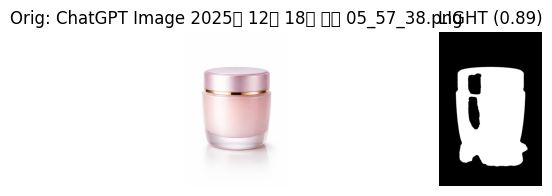

  1%|          | 1/117 [00:00<00:43,  2.69it/s]

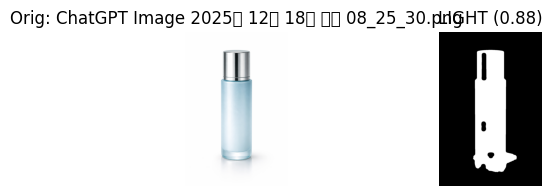

  2%|▏         | 2/117 [00:00<00:44,  2.59it/s]

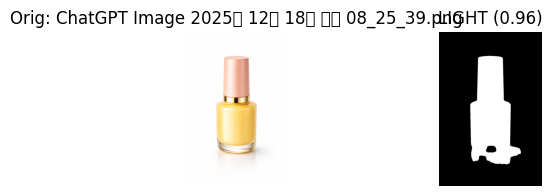

100%|██████████| 117/117 [00:26<00:00,  4.40it/s]



✅ Sorted Complete!
☀️ LIGHT : 60 images
🌑 DARK  : 57 images


In [11]:
# ================= CONFIGURATION =================
IN_DIR = r"C:\Users\nam\Desktop\bottle"       # 입력 폴더
OUT_DIR = r"C:\Users\nam\Desktop\bottle\sorted"    # 출력 폴더
MODE = "copy"           # "copy" (복사), "move" (이동) - 테스트 후 사용하세요
THRESHOLD = 0.60        # 밝기 기준
SHOW_SAMPLES = 3        # 샘플 확인 개수
# =================================================

in_path = Path(IN_DIR)
out_path = Path(OUT_DIR)
out_light = out_path / "LIGHT"
out_dark = out_path / "DARK"

# 폴더 생성
if MODE != "dryrun":
    out_light.mkdir(parents=True, exist_ok=True)
    out_dark.mkdir(parents=True, exist_ok=True)

files = [p for p in in_path.glob("**/*") if p.suffix.lower() in IMG_EXTS]
print(f"📂 Found {len(files)} images.")

# 카운터 초기화
count = {"LIGHT": 0, "DARK": 0, "ERROR": 0}

from tqdm import tqdm

for i, fpath in tqdm(enumerate(files), total=len(files)):
    try:
        bgr, alpha = load_image_with_alpha(fpath)
        mask = foreground_mask(bgr, alpha)
        score = calculate_perceived_brightness(bgr, mask)
        
        label = "LIGHT" if score >= THRESHOLD else "DARK"
        
        # 카운트 증가 (이 숫자가 파일명이 됩니다)
        count[label] += 1
        
        # --- 시각화 (디버깅용) ---
        if i < SHOW_SAMPLES:
            plt.figure(figsize=(6, 2))
            plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title(f"Orig: {fpath.name}")
            plt.subplot(1, 2, 2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title(f"{label} ({score:.2f})")
            plt.show()
        # -----------------------

        if MODE != "dryrun":
            target_dir = out_light if label == "LIGHT" else out_dark
            
            # [핵심 변경 사항] 파일명 넘버링 포맷팅
            # 예: LIGHT_00001.jpg, DARK_00015.png
            # :05d 는 숫자를 5자리로 맞추고 빈 곳을 0으로 채운다는 뜻입니다.
            ext = fpath.suffix # 원본 확장자 유지
            new_filename = f"{label}_{count[label]:05d}{ext}"
            
            dst_file = target_dir / new_filename
            
            # 만약 이미 파일이 있다면(재실행 등) _1, _2 등을 붙여 덮어쓰기 방지
            dup_cnt = 0
            while dst_file.exists():
                dup_cnt += 1
                dst_file = target_dir / f"{label}_{count[label]:05d}_{dup_cnt}{ext}"

            if MODE == "copy":
                dst_file.write_bytes(fpath.read_bytes())
            elif MODE == "move":
                shutil.move(str(fpath), str(dst_file))

    except Exception as e:
        count["ERROR"] += 1
        print(f"⚠️ Error {fpath.name}: {e}")

print(f"\n✅ Sorted Complete!")
print(f"☀️ LIGHT : {count['LIGHT']} images")
print(f"🌑 DARK  : {count['DARK']} images")